In [1]:
import pandas as pd
import numpy as np
import collections as coll
import urllib as ulib
import datetime as date
from pprint import pprint
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def getData(startdt=[15,7,4], savepath='/Users/ash/ds/projects/data/mta/mta_turnstile_summer2015data.csv'):
    """takes in start dt as a list [yy,m,d] and savepath as a string ('path/<file.txt>'); saves a big CSV file to this path
    which can be read in as a giant pandas dataframe."""
    
    #create filename url list (summer 2015 start date is 15,7,4)
    startdt = date.date(startdt[0],startdt[1],startdt[2])
    uri = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"
    urllist = [re.sub("-","",uri+str(startdt + date.timedelta(days=i))[2:]+str('.txt')) for i in np.arange(0,90,7)]
    
    #urllist = ["http://web.mta.info/developers/data/nyct/turnstile/turnstile_150704.txt",
    #           "http://web.mta.info/developers/data/nyct/turnstile/turnstile_150711.txt",
    #           "http://web.mta.info/developers/data/nyct/turnstile/turnstile_150718.txt"]
    
    
    #download from first url with header
    response = ulib.urlopen(urllist[0])
    df = pd.read_csv(response, 
                     header=0)
    #dfbig = pd.DataFrame({})
    response.close()
    
    #download from remaining urls and concatenate without header to dataframe
    for url in urllist[1:]:
        response = ulib.urlopen(url)
        df = pd.concat([df,pd.read_csv(response, 
                                       skiprows=1,
                                       skip_blank_lines=True)])
        response.close()
    
    df.drop(df.columns[[0,1,2,3,4,5,6,7,8,9,10]],axis=1)

    #df = pd.concat([df,dfbig], axis=0)
    #'/Users/ash/ds/projects/data/mta/mta-turnstile-summer2015data.csv'
    pd.DataFrame.to_csv(df, savepath)
        
            
    
    

In [3]:
#getData()

In [71]:
%%time
#Prepare data
df1 = pd.read_csv('/Users/ash/ds/projects/data/mta/mta_turnstile_summer2015data.csv')
df1.drop(df1.columns[0],axis=1, inplace=True)
df1.rename(columns=lambda x: x.strip(), inplace=True)
df1['DATE'] = pd.to_datetime(df1['DATE'])
df1['WEEKDAY'] = pd.DatetimeIndex(df1['DATE']).weekday
df1["INFLOW"]=df1.groupby(["C/A","UNIT","SCP","STATION","DATE"]).ENTRIES.diff()
df1["OUTFLOW"]=df1.groupby(["C/A","UNIT","SCP","STATION","DATE"]).EXITS.diff()
df1["FLUX"]=df1["INFLOW"]-df1["OUTFLOW"]
#temp = df1[(df1['INFLOW']>=0),]

CPU times: user 4min 42s, sys: 2.96 s, total: 4min 45s
Wall time: 4min 45s


In [77]:
#df1.head()

#more cleaning
#remove inflow < 0
df2 = df1.loc[(df1['INFLOW']>=0)&(df1['OUTFLOW']>=0),:]
df2.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,WEEKDAY,INFLOW,OUTFLOW,FLUX
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-06-27,04:00:00,REGULAR,5203840,1759886,5,56,7,49
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-06-27,08:00:00,REGULAR,5203860,1759910,5,20,24,-4
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-06-27,12:00:00,REGULAR,5203987,1759995,5,127,85,42
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-06-27,16:00:00,REGULAR,5204270,1760060,5,283,65,218
5,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-06-27,20:00:00,REGULAR,5204563,1760125,5,293,65,228


In [165]:
df_morning_inflow = df2.loc[((df2.TIME == "08:00:00")|(df2.TIME=="12:00:00"))&(df2.FLUX>0),["STATION","INFLOW","DATE","INFLOW","OUTFLOW","FLUX"]]
#aggregate sums for morning
df_morning_inflow['FLUXscaled']=(df_morning_inflow.FLUX-df_morning_inflow.FLUX.mean())/(df_morning_inflow.FLUX.max()-df_morning_inflow.FLUX.min())
morning_grp=df_morning_inflow.groupby(['DATE','STATION']).FLUX.sum()
#df_morning=morning_grp.reset_index()

#df_morning.groupby(['DATE','STATION'])['FLUX'].nlargest(3).reset_index(level=3, drop=True)

(df_morning
 .sort_values(['DATE','FLUX'], ascending=[True,False])
 .groupby('DATE')
 .head(5)
 )

#df_morning.unstack(level='STATION')
#df_morning.groupby(['DATE','STATION'])['FLUX'].nlargest(5)
#scale flux
#df_morning_inflow['FLUXscaled']=(df_morning_inflow.FLUX-df_morning_inflow.FLUX.mean())/(df_morning_inflow.FLUX.max()-df_morning_inflow.FLUX.min())
#df_morning_inflow.head()



#df1[columns].set_index("DATE").plot.line(figsize=(20,10))



,DATE,STATION,FLUX
121,2015-06-27,CROWN HTS-UTICA,8354
182,2015-06-27,ROOSEVELT AVE,7852
160,2015-06-27,MAIN ST,7754
72,2015-06-27,86 ST,6696
1,2015-06-27,103 ST-CORONA,5866
327,2015-06-28,CROWN HTS-UTICA,5677
389,2015-06-28,ROOSEVELT AVE,5520
366,2015-06-28,MAIN ST,5455
278,2015-06-28,86 ST,5240
215,2015-06-28,145 ST,4726


TypeError: There is no Line2D property "columns"

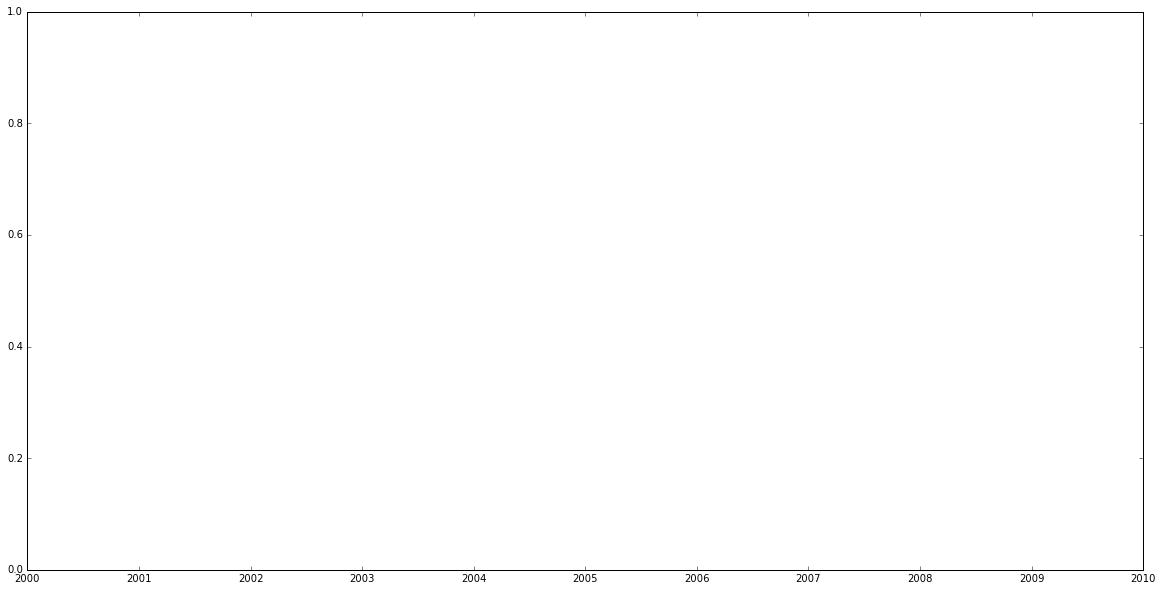

In [162]:
# PLOT 1: MORNING, TOP 5 STATIONS with MAX PEOPLE COMING IN (TIME SERIES VIEW FOR SUMMER 2015)
#df_morning_inflow.sort_values(['STATION','DATE','FLUX'], ascending = [True, True, False] )
#df_morning_inflow.groupby(['STATION','DATE'])['FLUX'].nlargest(3).reset_index(level=2, drop=True)


df_morning.plot.line(
    x='DATE',
    y='FLUX',
    figsize=(20,10))

In [ ]:
#df1.iloc[len(df1)-10:len(df1),:]

#df1.info()

#df1.head(10)

#df1.columns
#df1.rename(columns=lambda x: x.strip(), inplace=True)
#df1['DATE'] = pd.to_datetime(df1['DATE’])


#mta['Weekday'] = mta['DATE']
#temp = pd.DatetimeIndex(mta['Weekday'])
#mta['Weekday'] = temp.weekday
#df1.DESC.isnull().sum()

#df1.sort_values(by=["SCP","STATION","DATE"], inplace=True)
#df2 = df1.head(1000)

#df2.head()

#df1.boxplot(['DESC'].value_counts(), by="DESC")


# if final is a group by object, then we can chain and undo 
#(df1
#      .reset_index()
#      .sort_values(["DATE","dTOTAL"]), ascending=[True,False]
#)
# Some cleaning...

## check for missing values: none
#df1.isnull().sum()

## recovered audits?
#print("approx. % of entries classified as 'Recovered' Audits", round(df1.groupby("DESC").size()[0]*100/float(df1.groupby("DESC").size()[1]),4))
#df1.loc[df1["DESC"]=="RECOVR AUD"]

#plot recovered audits by station




#df1.rename(columns = {'EXITS':'EXITS'}, inplace=True)
#df1.loc[::6,].head()
## Unusual numerics?


### first, cleanup the entries and exits
# df2.groupby(["STATION","SCP","DATE"]).ENTRIES.agg(['median','mean'])
#grouped = df2.groupby(["SCP","STATION","DATE"]).groups
#entries = pd.Series()
#df2["numEntries"]=0

#for key, val in sorted(grouped.items()):
#    entries.append(pd.Series(abs(df2["ENTRIES"][val].shift(+1)-df2["ENTRIES"][val])))

#df2.loc[:,"numEntries"] = entries
#pprint(entries)

#df1.sort_values(by=["SCP","STATION","DATE"], inplace=True)
#df1.head()